In [1]:
# -*- coding: utf-8 -*-
import os
import pandas as pd
import numpy as np
from PIL import Image
import gc, math
import pickle

from keras.models import Sequential
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.models import model_from_json
from keras.models import Model
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, Flatten, merge, Reshape, Activation
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras import backend as K
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline  

from sklearn.metrics import log_loss, accuracy_score, confusion_matrix

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
def identity_block(input_tensor, kernel_size, filters, stage, block):
    """
    The identity_block is the block that has no conv layer at shortcut
    Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the nb_filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    """

    nb_filter1, nb_filter2, nb_filter3 = filters
    bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Convolution2D(nb_filter1, 1, 1, name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Convolution2D(nb_filter2, kernel_size, kernel_size,
                      border_mode='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Convolution2D(nb_filter3, 1, 1, name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = merge([x, input_tensor], mode='sum')
    x = Activation('relu')(x)
    return x

def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    """
    conv_block is the block that has a conv layer at shortcut
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the nb_filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    Note that from stage 3, the first conv layer at main path is with subsample=(2,2)
    And the shortcut should have subsample=(2,2) as well
    """

    nb_filter1, nb_filter2, nb_filter3 = filters
    bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Convolution2D(nb_filter1, 1, 1, subsample=strides,
                      name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Convolution2D(nb_filter2, kernel_size, kernel_size, border_mode='same',
                      name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Convolution2D(nb_filter3, 1, 1, name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Convolution2D(nb_filter3, 1, 1, subsample=strides,
                             name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = merge([x, shortcut], mode='sum')
    x = Activation('relu')(x)
    return x

def resnet50_model(img_rows, img_cols, color_type=1, num_class=None):
    """
    Resnet 50 Model for Keras
    Model Schema is based on 
    https://github.com/fchollet/deep-learning-models/blob/master/resnet50.py
    ImageNet Pretrained Weights 
    https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_th_dim_ordering_th_kernels.h5
    Parameters:
      img_rows, img_cols - resolution of inputs
      channel - 1 for grayscale, 3 for color 
      num_class - number of class labels for our classification task
    """

    bn_axis = 1
    img_input = Input(shape=(color_type, img_rows, img_cols))
    x = ZeroPadding2D((3, 3))(img_input)
    x = Convolution2D(64, 7, 7, subsample=(2, 2), name='conv1')(x)
    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

    # Fully Connected Softmax Layer
    x_fc = AveragePooling2D((7, 7), name='avg_pool')(x)
    x_fc = Flatten()(x_fc)
    x_fc = Dense(1000, activation='softmax', name='fc1000')(x_fc)

    # Create model
    model = Model(img_input, x_fc)

    # Load ImageNet pre-trained data 
    model.load_weights('../cache/resnet50_weights_th_dim_ordering_th_kernels.h5')

    # Truncate and replace softmax layer for transfer learning
    # Cannot use model.layers.pop() since model is not of Sequential() type
    # The method below works since pre-trained weights are stored in layers but not in the model
    x_newfc = AveragePooling2D((7, 7), name='avg_pool')(x)
    x_newfc = Flatten()(x_newfc)
    x_newfc = Dense(num_class, activation='softmax', name='fc10')(x_newfc)

    # Create another model with our customized softmax
    model = Model(img_input, x_newfc)

    # Learning rate is changed to 0.001
    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
  
    return model

In [3]:
# Functions
def preprocess_input(x):
    #resnet50 image preprocessing
    # 'RGB'->'BGR'
    x = x[:, :, ::-1]
    x[:, :, 0] -= 100
    x[:, :, 1] -= 115
    x[:, :, 2] -= 124
    return x

def create_rect5(row):
    if is_seal:
        return plt.Rectangle((row['x0'], row['y0']), row['w'], row['h'], color='red', fill=False, lw=2)
    else:
        return plt.Rectangle((row['x0'], row['y0']), row['w'], row['h'], color='red', fill=False, lw=4)

def load_img(path, bbox, target_size=None):
    img = Image.open(path)
    img = img.convert('RGB')
    cropped = img.crop((bbox[0],bbox[1],bbox[2],bbox[3]))
    if target_size:
        cropped = cropped.resize((target_size[1], target_size[0]))
    return cropped

In [4]:
# Params
img_rows, img_cols = 224, 224 # Resolution of inputs
channel = 3
num_class = 2
ROWS, COLS = 224, 224
BATCHSIZE = 32
SEAL_CLASSES = ['NoS', 'seal']
nb_perClass = int(BATCHSIZE / len(SEAL_CLASSES))
TRAIN_DIR = '../darknet/seals/JPEGImagesBlk'
TEST_DIR = '../darknet/seals/JPEGImagesTest'

In [5]:
# Fine-tune Example
rfcnCV = pd.read_pickle('../coords/rfcnCVlo06.pkl')
rfcnCV.head(3)

,img,proba,x0,y0,x1,y1,seal
0,228_54,0.894,364.95,295.10,464.95,395.10,0
1,228_54,0.893,228.20,376.30,328.20,476.30,0
2,228_54,0.720,407.75,409.95,507.75,509.95,0


In [6]:
rfcnCV.shape

(264142, 7)

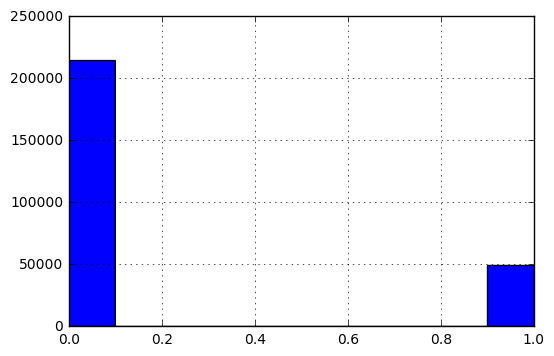

In [7]:
rfcnCV.seal.hist()

In [8]:
# Fine-tune Example
test_df = pd.read_pickle('../coords/rfcnTstlo06.pkl')
test_df.head(3)

,img,proba,x0,y0,x1,y1
0,13835_33,0.967,0.0,444.0,100.0,544.0
1,13835_33,0.638,0.0,0.0,100.0,100.0
2,13835_33,0.635,444.0,0.0,544.0,100.0


In [9]:
test_df.shape

(4776936, 6)

In [10]:
def train_generator(datagen, df):
    while 1:
        batch_x = np.zeros((BATCHSIZE, ROWS, COLS, 3), dtype=K.floatx())
        batch_y = np.zeros((BATCHSIZE, len(SEAL_CLASSES)), dtype=K.floatx())
        fn = lambda obj: obj.loc[np.random.choice(obj.index, size=nb_perClass, replace=False),:]
        batch_df = df.groupby(['seal'], as_index=True).apply(fn)
        i = 0
        for index,row in batch_df.iterrows():
            row = row.tolist()
            image_file = os.path.join(TRAIN_DIR, row[0])
            seal = row[6]
            bbox = row[2:6]
            cropped = load_img(image_file+'.jpg',bbox,target_size=(ROWS,COLS))
            x = np.asarray(cropped, dtype=K.floatx())
            x = datagen.random_transform(x)
            x = preprocess_input(x)
            batch_x[i] = x
            batch_y[i,seal] = 1
            i += 1
        yield (batch_x.transpose(0, 3, 1, 2), batch_y)

def test_generator(df, datagen = None, batch_size = BATCHSIZE):
    n = df.shape[0]
    batch_index = 0
    while 1:
        current_index = batch_index * batch_size
        if n >= current_index + batch_size:
            current_batch_size = batch_size
            batch_index += 1    
        else:
            current_batch_size = n - current_index
            batch_index = 0        
        batch_df = df[current_index:current_index+current_batch_size]
        batch_x = np.zeros((batch_df.shape[0], ROWS, COLS, 3), dtype=K.floatx())
        i = 0
        for index,row in batch_df.iterrows():
            row = row.tolist()
            image_file = os.path.join(TEST_DIR, row[0]+'.jpg')
            bbox = row[2:6]
            cropped = load_img(image_file,bbox,target_size=(ROWS,COLS))
            x = np.asarray(cropped, dtype=K.floatx())
            if datagen is not None: x = datagen.random_transform(x)            
            x = preprocess_input(x)
            batch_x[i] = x
            i += 1
        if batch_index%50 == 0: print(batch_index)
        #return(batch_x.transpose(0, 3, 1, 2))
        yield(batch_x.transpose(0, 3, 1, 2))
        
# Data generator
train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True)

In [11]:
# Lets make our validation set
CVsplit = rfcnCV.img.str.split('_').apply(lambda x: x[0]).astype(int) % 40 == 0
train_df = rfcnCV[~CVsplit]
valid_df = rfcnCV[CVsplit]

# validation_data (valid_x,valid_y)
df_1 = valid_df
l = valid_df.groupby('seal').size()
nb_NoF_valid = math.ceil(l.sum()/10)
valid_x = np.zeros((valid_df.shape[0], ROWS, COLS, 3), dtype=K.floatx())
valid_y = np.zeros((valid_df.shape[0], len(SEAL_CLASSES)), dtype=K.floatx())
i = 0
for index,row in valid_df.iterrows():
    row = row.tolist()
    image_file = os.path.join(TRAIN_DIR, row[0])
    seal = row[6]
    bbox = row[2:6]
    cropped = load_img(image_file+'.jpg',bbox,target_size=(ROWS,COLS))
    x = np.asarray(cropped, dtype=K.floatx())
    x = preprocess_input(x)
    valid_x[i] = x
    valid_y[i,seal] = 1
    i += 1
valid_x = valid_x.transpose(0, 3, 1, 2)
valid_x.shape

(5898, 3, 224, 224)

In [12]:
#model = resnet50_model(ROWS, COLS, channel, num_class)
#model.summary()

In [ ]:
# Load our model
nb_epoch = 2
samples_per_epoch = 140000
model = resnet50_model(ROWS, COLS, channel, num_class)
for layer in model.layers:
    layer.trainable = False
for layer in model.layers[-3:]:
    layer.trainable = True

# Start Fine-tuning
model.fit_generator(train_generator(train_datagen, train_df),
          nb_epoch=nb_epoch,
          samples_per_epoch=samples_per_epoch, #50000,
          verbose=1,
          validation_data=(valid_x, valid_y),
          )

Epoch 1/2
140000/140000 [==============================] - 7432s - loss: 0.0821 - acc: 0.9710 - val_loss: 0.0993 - val_acc: 0.9674
Epoch 2/2
140000/140000 [==============================] - 7405s - loss: 0.0506 - acc: 0.9830 - val_loss: 0.0615 - val_acc: 0.9798


In [ ]:
for layer in model.layers[38:]:
    layer.trainable = True
model.optimizer.lr = 1e-5
nb_epoch = 6
model.fit_generator(train_generator(train_datagen, df=train_df),
          nb_epoch=nb_epoch,
          samples_per_epoch=samples_per_epoch,
          verbose=1,
          validation_data=(valid_x, valid_y),
          )

Epoch 1/6
   448/140000 [..............................] - ETA: 7670s - loss: 0.0465 - acc: 0.9844

In [ ]:
# test_preds = test_model.predict_generator(test_generator(test_df), val_samples=test_df.shape[0]))
test_preds = model.predict_generator(test_generator(test_df), val_samples=test_df.shape[0])

In [ ]:
df = pd.concat([test_df, pd.DataFrame(test_preds,  columns=['predNoSeal', 'predSeal'])], axis=1)
df.to_pickle('../coords/resnet50TestPredslo06_0105.pkl')

In [ ]:
df[['img', 'predSeal']].to_csv('../coords/resnet50TestPredslo06_0105.csv', index=False)
df.head(5)

In [ ]:
model.summary()

In [ ]:
model.save('checkpoints/model_resnet50TestPreds_lo06_0105.h5')